In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# print(images.shape)
# print(labels.shape)

# # Let's visualize some of the images
# # %matplotlib inline
# # import matplotlib.pyplot as plt

# # plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [0]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# figure = plt.figure()
# num_of_images = 60
# for index in range(1, num_of_images + 1):
#     plt.subplot(6, 10, index)
#     plt.axis('off')
#     plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Input Block ## 160
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1 2304+16
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),     
            nn.BatchNorm2d(14),
            nn.ReLU()
        ) # output_size = 24        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
            
        ) # output_size = 22

        # TRANSITION BLOCK 1  ##1440 +16
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11


        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 7


    # # CONVOLUTION BLOCK 3
    #     self.convblock7 = nn.Sequential(
    #         nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
    #         nn.ReLU()
    #     ) # output_size = 7
    #     self.convblock8 = nn.Sequential(
    #         nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
    #         # nn.ReLU() NEVER!
    #     ) # output_size = 5
        # self.pool2 = nn.MaxPool2d(2, 2) # output_size = 3
     # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 5
        # self.convblock8 = nn.Sequential(
        #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
        #     # nn.ReLU() NEVER!
        # ) # output_size = 1
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1
        self.dropout = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.05)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.dropout(x)
        x = self.convblock2(x)
        x = self.dropout(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.dropout(x)
        x = self.convblock5(x)
        x = self.dropout(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        # x = self.pool2(x)
        x = self.convblock7(x)
        x = self.dropout2(x)
        # x = self.convblock8(x)
        x= self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 14, 24, 24]           1,260
       BatchNorm2d-6           [-1, 14, 24, 24]              28
              ReLU-7           [-1, 14, 24, 24]               0
           Dropout-8           [-1, 14, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           2,016
      BatchNorm2d-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
        MaxPool2d-12           [-1, 16, 11, 11]               0
           Conv2d-13           [-1, 10, 11, 11]             160
      BatchNorm2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

# Let's Train and test our model

In [0]:
from tqdm.auto import tqdm, trange
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device("cuda" if use_cuda else "cpu")

def train(epochs, l1, l2,model):
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95,weight_decay=l2)
    F.nll_loss
    train_losses = []
    test_losses  = []
    train_acc    = []
    test_acc     = []
    # lr_values    = []

    print('Training the model for {} epochs'.format(epochs))

    for epoch in range(1, epochs+1):
        print('EPOCH:', epoch)

        # train the model
        tr_acc,tr_loss,model =train_epoch(epoch,l1,l2,optimizer)

        # validate the model
        tst_acc,tst_loss =test(model,test_loader)

        train_acc.append(tr_acc)
        train_losses.append(tr_loss)
        test_acc.append(tst_acc)
        test_losses.append(tst_loss)
    
    return ((train_acc, train_losses), (test_acc, test_losses),model)

def train_epoch(epoch,l1,l2,optimizer):
    device = torch.device("cuda" if use_cuda else "cpu")
    train_acc  = []
    train_loss = []
    lr_values  = []

    correct = 0
    processed = 0

    model.train()

    pbar = tqdm(train_loader, ncols="80%")

    for batch_idx, (data, target) in enumerate(pbar):

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        # Predict
        y_pred = model(data)

        # Calculate loss
        only_loss = F.nll_loss(y_pred, target)

        l1_reg_loss = sum([torch.sum(abs(param)) for param in model.parameters()])

        if l1 > 0:
            # l1 regularization
            l1_loss = sum([torch.sum(abs(param)) for param in model.parameters()])

            loss = only_loss + 0.0005 * l1_loss
        else:
            loss = only_loss

        train_loss.append(loss.data.cpu().numpy().item())

        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # get the index of the max log-probability
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        # Update pbar-tqdm
        # pbar.set_description(desc= f'epoch={epoch} loss={loss.item()} batch_id={batch_idx} accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

    return (train_acc, train_loss,model)
def test(model,test_loader):
    device = torch.device("cuda" if use_cuda else "cpu")
    test_losses = []
    test_acc    = []

    # set the model in evaluation mode
    model.eval()

    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return (test_acc, test_losses)


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.style.use("dark_background")

def plot_metrics(train_related, test_related):
    (tr_acc, tr_losses) = train_related
    (tst_acc, tst_losses) = test_related

    fig, axs = plt.subplots(2,2,figsize=(14,10))
    fig.suptitle('Metrics')
    axs[0, 0].plot(tr_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(tr_acc)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(tst_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(tst_acc)
    axs[1, 1].set_title("Test Accuracy")
    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def get_misclassified(model,test_loader):
    device = torch.device("cuda" if use_cuda else "cpu")
    misclassified = []
    misclassified_pred = []
    misclassified_target = []
    # put the model to evaluation mode
    model.eval()
    # turn off gradients
    with torch.no_grad():
        for data, target in test_loader:
            # move them to the respective device
            data, target = data.to(device), target.to(device)
            # do inferencing
            output = model(data)
            # get the predicted output
            pred = output.argmax(dim=1, keepdim=True)

            # get the current misclassified in this batch
            list_misclassified = (pred.eq(target.view_as(pred)) == False)
            batch_misclassified = data[list_misclassified]
            batch_mis_pred = pred[list_misclassified]
            batch_mis_target = target.view_as(pred)[list_misclassified]

            # batch_misclassified =

            misclassified.append(batch_misclassified)
            misclassified_pred.append(batch_mis_pred)
            misclassified_target.append(batch_mis_target)

    # group all the batched together
    misclassified = torch.cat(misclassified)
    misclassified_pred = torch.cat(misclassified_pred)
    misclassified_target = torch.cat(misclassified_target)

    return list(map(lambda x, y, z: (x, y, z), misclassified, misclassified_pred, misclassified_target))

In [0]:
def get_classified_correctly(model,test_loader):
    device = torch.device("cuda" if use_cuda else "cpu")
    misclassified = []
    misclassified_pred = []
    misclassified_target = []
    # put the model to evaluation mode
    model.eval()
    # turn off gradients
    with torch.no_grad():
        for data, target in test_loader:
            # move them to the respective device
            data, target = data.to(device), target.to(device)
            # do inferencing
            output = model(data)
            # get the predicted output
            pred = output.argmax(dim=1, keepdim=True)

            # get the current misclassified in this batch
            list_misclassified = (pred.eq(target.view_as(pred)) == True)
            batch_misclassified = data[list_misclassified]
            batch_mis_pred = pred[list_misclassified]
            batch_mis_target = target.view_as(pred)[list_misclassified]

            # batch_misclassified =

            misclassified.append(batch_misclassified)
            misclassified_pred.append(batch_mis_pred)
            misclassified_target.append(batch_mis_target)

    # group all the batched together
    misclassified = torch.cat(misclassified)
    misclassified_pred = torch.cat(misclassified_pred)
    misclassified_target = torch.cat(misclassified_target)

    return list(map(lambda x, y, z: (x, y, z), misclassified, misclassified_pred, misclassified_target))

In [0]:
def plot_misclassification(misclassified):
    print('Total Misclassifications : {}'.format(len(misclassified)))
    num_images = 25
    fig = plt.figure(figsize=(12, 14))
    fig.suptitle('Misclassifications')
    for idx, (image, pred, target) in enumerate(misclassified[:num_images]):
        image, pred, target = image.cpu().numpy(), pred.cpu(), target.cpu()
        ax = fig.add_subplot(5, 5, idx+1)
        ax.axis('off')
        ax.set_title('target {}\npred {}'.format(target.item(), pred.item()), fontsize=12)
        ax.imshow(image.squeeze())
    plt.show()
    return fig

In [0]:
def plot_classification_correctly(misclassified):
    print('Total correctly classified : {}'.format(len(misclassified)))
    num_images = 25
    fig = plt.figure(figsize=(12, 14))
    fig.suptitle('correctly classified')
    for idx, (image, pred, target) in enumerate(misclassified[:num_images]):
        image, pred, target = image.cpu().numpy(), pred.cpu(), target.cpu()
        ax = fig.add_subplot(5, 5, idx+1)
        ax.axis('off')
        ax.set_title('target {}\npred {}'.format(target.item(), pred.item()), fontsize=12)
        ax.imshow(image.squeeze())
    plt.show()
    return fig

without L1 L2 with BN!!!!!!!!!!
Training the model for 25 epochs
EPOCH: 1




Test set: Average loss: 0.0768, Accuracy: 9792/10000 (97.92%)

EPOCH: 2




Test set: Average loss: 0.0555, Accuracy: 9829/10000 (98.29%)

EPOCH: 3




Test set: Average loss: 0.0375, Accuracy: 9889/10000 (98.89%)

EPOCH: 4




Test set: Average loss: 0.0324, Accuracy: 9908/10000 (99.08%)

EPOCH: 5




Test set: Average loss: 0.0298, Accuracy: 9908/10000 (99.08%)

EPOCH: 6




Test set: Average loss: 0.0328, Accuracy: 9898/10000 (98.98%)

EPOCH: 7




Test set: Average loss: 0.0297, Accuracy: 9906/10000 (99.06%)

EPOCH: 8




Test set: Average loss: 0.0263, Accuracy: 9909/10000 (99.09%)

EPOCH: 9




Test set: Average loss: 0.0309, Accuracy: 9903/10000 (99.03%)

EPOCH: 10




Test set: Average loss: 0.0288, Accuracy: 9910/10000 (99.10%)

EPOCH: 11




Test set: Average loss: 0.0257, Accuracy: 9927/10000 (99.27%)

EPOCH: 12




Test set: Average loss: 0.0254, Accuracy: 9920/10000 (99.20%)

EPOCH: 13




Test set: Average loss: 0.0221, Accuracy: 9932/10000 (99.32%)

EPOCH: 14




Test set: Average loss: 0.0246, Accuracy: 9921/10000 (99.21%)

EPOCH: 15




Test set: Average loss: 0.0245, Accuracy: 9928/10000 (99.28%)

EPOCH: 16




Test set: Average loss: 0.0229, Accuracy: 9926/10000 (99.26%)

EPOCH: 17




Test set: Average loss: 0.0230, Accuracy: 9924/10000 (99.24%)

EPOCH: 18




Test set: Average loss: 0.0211, Accuracy: 9931/10000 (99.31%)

EPOCH: 19




Test set: Average loss: 0.0233, Accuracy: 9932/10000 (99.32%)

EPOCH: 20




Test set: Average loss: 0.0201, Accuracy: 9938/10000 (99.38%)

EPOCH: 21




Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)

EPOCH: 22




Test set: Average loss: 0.0182, Accuracy: 9942/10000 (99.42%)

EPOCH: 23




Test set: Average loss: 0.0216, Accuracy: 9929/10000 (99.29%)

EPOCH: 24




Test set: Average loss: 0.0214, Accuracy: 9940/10000 (99.40%)

EPOCH: 25




Test set: Average loss: 0.0197, Accuracy: 9936/10000 (99.36%)

with L1 with BN!!!!!!!!!!
Training the model for 25 epochs
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "




Test set: Average loss: 0.1059, Accuracy: 9686/10000 (96.86%)

EPOCH: 2




Test set: Average loss: 0.0573, Accuracy: 9851/10000 (98.51%)

EPOCH: 3




Test set: Average loss: 0.0640, Accuracy: 9809/10000 (98.09%)

EPOCH: 4




Test set: Average loss: 0.0605, Accuracy: 9811/10000 (98.11%)

EPOCH: 5




Test set: Average loss: 0.0456, Accuracy: 9865/10000 (98.65%)

EPOCH: 6




Test set: Average loss: 0.0633, Accuracy: 9807/10000 (98.07%)

EPOCH: 7




Test set: Average loss: 0.0503, Accuracy: 9844/10000 (98.44%)

EPOCH: 8




Test set: Average loss: 0.0662, Accuracy: 9786/10000 (97.86%)

EPOCH: 9




Test set: Average loss: 0.0673, Accuracy: 9796/10000 (97.96%)

EPOCH: 10




Test set: Average loss: 0.0599, Accuracy: 9812/10000 (98.12%)

EPOCH: 11




Test set: Average loss: 0.0478, Accuracy: 9853/10000 (98.53%)

EPOCH: 12




Test set: Average loss: 0.0405, Accuracy: 9875/10000 (98.75%)

EPOCH: 13




Test set: Average loss: 0.0635, Accuracy: 9804/10000 (98.04%)

EPOCH: 14




Test set: Average loss: 0.0707, Accuracy: 9782/10000 (97.82%)

EPOCH: 15




Test set: Average loss: 0.0862, Accuracy: 9704/10000 (97.04%)

EPOCH: 16




Test set: Average loss: 0.0409, Accuracy: 9878/10000 (98.78%)

EPOCH: 17




Test set: Average loss: 0.0881, Accuracy: 9730/10000 (97.30%)

EPOCH: 18




Test set: Average loss: 0.0720, Accuracy: 9789/10000 (97.89%)

EPOCH: 19




Test set: Average loss: 0.0496, Accuracy: 9870/10000 (98.70%)

EPOCH: 20




Test set: Average loss: 0.0474, Accuracy: 9859/10000 (98.59%)

EPOCH: 21




Test set: Average loss: 0.0457, Accuracy: 9865/10000 (98.65%)

EPOCH: 22




Test set: Average loss: 0.0596, Accuracy: 9822/10000 (98.22%)

EPOCH: 23




Test set: Average loss: 0.0559, Accuracy: 9823/10000 (98.23%)

EPOCH: 24




Test set: Average loss: 0.0580, Accuracy: 9835/10000 (98.35%)

EPOCH: 25




Test set: Average loss: 0.0626, Accuracy: 9809/10000 (98.09%)

with L2 with BN!!!!!!!!!!
Training the model for 25 epochs
EPOCH: 1




Test set: Average loss: 0.0933, Accuracy: 9736/10000 (97.36%)

EPOCH: 2




Test set: Average loss: 0.0537, Accuracy: 9815/10000 (98.15%)

EPOCH: 3




Test set: Average loss: 0.0301, Accuracy: 9904/10000 (99.04%)

EPOCH: 4




Test set: Average loss: 0.0307, Accuracy: 9902/10000 (99.02%)

EPOCH: 5




Test set: Average loss: 0.0259, Accuracy: 9915/10000 (99.15%)

EPOCH: 6




Test set: Average loss: 0.0244, Accuracy: 9923/10000 (99.23%)

EPOCH: 7




Test set: Average loss: 0.0234, Accuracy: 9929/10000 (99.29%)

EPOCH: 8




Test set: Average loss: 0.0247, Accuracy: 9917/10000 (99.17%)

EPOCH: 9




Test set: Average loss: 0.0218, Accuracy: 9924/10000 (99.24%)

EPOCH: 10




Test set: Average loss: 0.0255, Accuracy: 9928/10000 (99.28%)

EPOCH: 11




Test set: Average loss: 0.0232, Accuracy: 9921/10000 (99.21%)

EPOCH: 12




Test set: Average loss: 0.0208, Accuracy: 9934/10000 (99.34%)

EPOCH: 13




Test set: Average loss: 0.0228, Accuracy: 9921/10000 (99.21%)

EPOCH: 14




Test set: Average loss: 0.0205, Accuracy: 9928/10000 (99.28%)

EPOCH: 15




Test set: Average loss: 0.0199, Accuracy: 9932/10000 (99.32%)

EPOCH: 16




Test set: Average loss: 0.0196, Accuracy: 9942/10000 (99.42%)

EPOCH: 17




Test set: Average loss: 0.0202, Accuracy: 9943/10000 (99.43%)

EPOCH: 18




Test set: Average loss: 0.0207, Accuracy: 9941/10000 (99.41%)

EPOCH: 19




Test set: Average loss: 0.0193, Accuracy: 9943/10000 (99.43%)

EPOCH: 20




Test set: Average loss: 0.0177, Accuracy: 9945/10000 (99.45%)

EPOCH: 21




Test set: Average loss: 0.0189, Accuracy: 9940/10000 (99.40%)

EPOCH: 22




Test set: Average loss: 0.0190, Accuracy: 9938/10000 (99.38%)

EPOCH: 23




Test set: Average loss: 0.0175, Accuracy: 9945/10000 (99.45%)

EPOCH: 24




Test set: Average loss: 0.0217, Accuracy: 9922/10000 (99.22%)

EPOCH: 25




Test set: Average loss: 0.0192, Accuracy: 9937/10000 (99.37%)

with L1 and L2 with BN!!!!!!!!!!
Training the model for 25 epochs
EPOCH: 1




Test set: Average loss: 0.0867, Accuracy: 9756/10000 (97.56%)

EPOCH: 2




Test set: Average loss: 0.0631, Accuracy: 9811/10000 (98.11%)

EPOCH: 3




Test set: Average loss: 0.0705, Accuracy: 9791/10000 (97.91%)

EPOCH: 4




Test set: Average loss: 0.0483, Accuracy: 9853/10000 (98.53%)

EPOCH: 5




Test set: Average loss: 0.0576, Accuracy: 9814/10000 (98.14%)

EPOCH: 6




Test set: Average loss: 0.0517, Accuracy: 9835/10000 (98.35%)

EPOCH: 7




Test set: Average loss: 0.0473, Accuracy: 9853/10000 (98.53%)

EPOCH: 8




Test set: Average loss: 0.0533, Accuracy: 9825/10000 (98.25%)

EPOCH: 9




Test set: Average loss: 0.0542, Accuracy: 9844/10000 (98.44%)

EPOCH: 10




Test set: Average loss: 0.0480, Accuracy: 9851/10000 (98.51%)

EPOCH: 11




Test set: Average loss: 0.0552, Accuracy: 9823/10000 (98.23%)

EPOCH: 12




Test set: Average loss: 0.0494, Accuracy: 9843/10000 (98.43%)

EPOCH: 13




Test set: Average loss: 0.0398, Accuracy: 9871/10000 (98.71%)

EPOCH: 14




Test set: Average loss: 0.0536, Accuracy: 9827/10000 (98.27%)

EPOCH: 15




Test set: Average loss: 0.0528, Accuracy: 9836/10000 (98.36%)

EPOCH: 16




Test set: Average loss: 0.0518, Accuracy: 9843/10000 (98.43%)

EPOCH: 17




Test set: Average loss: 0.0552, Accuracy: 9830/10000 (98.30%)

EPOCH: 18




Test set: Average loss: 0.0782, Accuracy: 9760/10000 (97.60%)

EPOCH: 19




Test set: Average loss: 0.0634, Accuracy: 9800/10000 (98.00%)

EPOCH: 20




Test set: Average loss: 0.0600, Accuracy: 9807/10000 (98.07%)

EPOCH: 21




Test set: Average loss: 0.0636, Accuracy: 9803/10000 (98.03%)

EPOCH: 22




Test set: Average loss: 0.0600, Accuracy: 9805/10000 (98.05%)

EPOCH: 23




Test set: Average loss: 0.0488, Accuracy: 9836/10000 (98.36%)

EPOCH: 24




Test set: Average loss: 0.0570, Accuracy: 9812/10000 (98.12%)

EPOCH: 25




Test set: Average loss: 0.0552, Accuracy: 9827/10000 (98.27%)



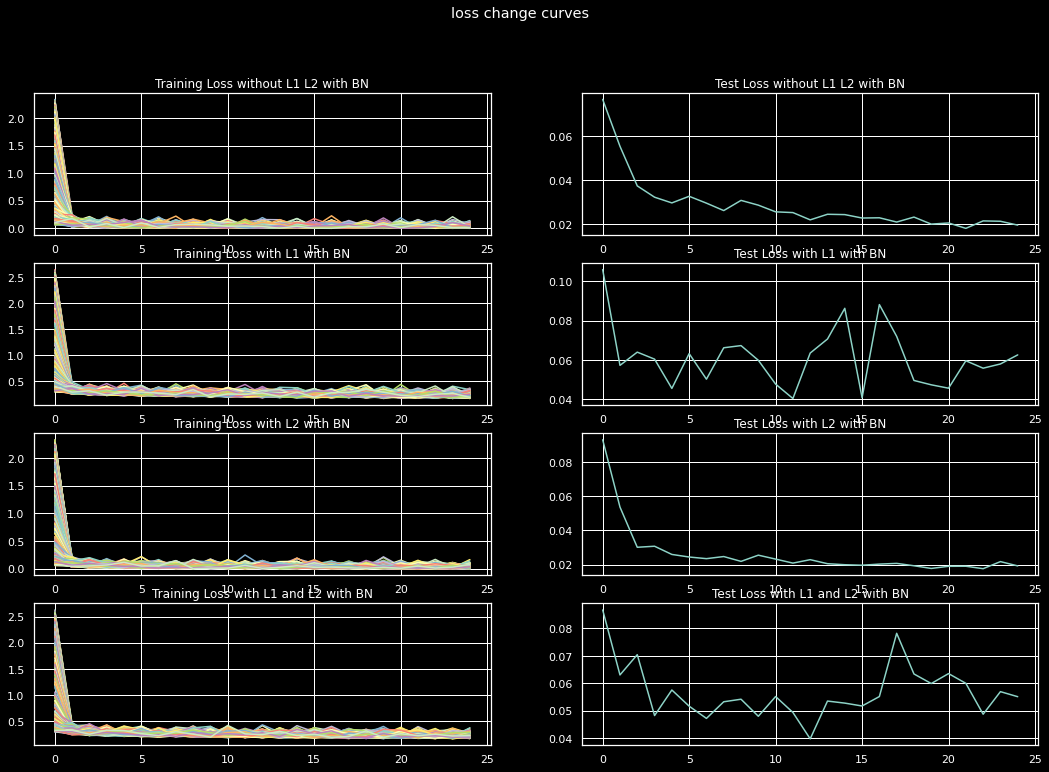

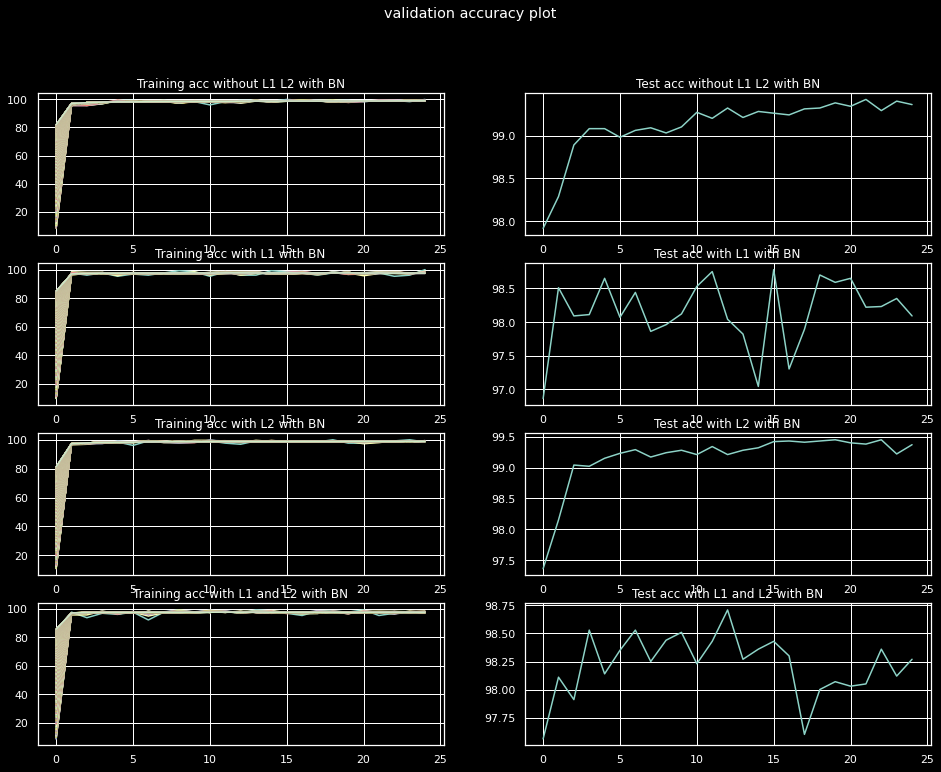

In [26]:
training_logs_dict={}
input_dict={"without L1 L2 with BN":{"l1":0,"l2":0},
            "with L1 with BN":{"l1":1,"l2":0},
            "with L2 with BN":{"l1":0,"l2": 0.0001},
            "with L1 and L2 with BN":{"l1":1,"l2": 0.0001}
            }
fig, axs = plt.subplots(4,2,figsize=(18,12))
fig2,axs2=plt.subplots(4,2,figsize=(16,12))
fig2.suptitle('validation accuracy plot')
fig.suptitle('loss change curves')
for j,comb in enumerate(input_dict):
  model = Net().to(device)
  print(comb+"!!!!!!!!!!")
  train_related,test_related,model=train(25, input_dict[comb]["l1"], input_dict[comb]["l2"],model)
  (tr_acc, tr_losses) = train_related
  (tst_acc, tst_losses) = test_related
  # misclassified = get_misclassified(model,test_loader)
  # plot_metrics(train_related, test_related)
  # plot_misclassification(misclassified)
  # classified_correctly = get_classified_correctly(model,test_loader)
  # training_logs_dict.update({comb:{"train_related":train_related,"test_related":test_related,"misclassified":misclassified,"classified_correctly":classified_correctly}})
  axs[j, 0].plot(tr_losses)
  axs[j, 0].set_title("Training Loss "+ str(comb))
  axs[j, 1].plot(tst_losses)
  axs[j, 1].set_title("Test Loss "+str(comb))

  axs2[j, 0].plot(tr_acc)
  axs2[j, 0].set_title("Training acc "+ str(comb))
  axs2[j, 1].plot(tst_acc)
  axs2[j, 1].set_title("Test acc "+str(comb))

  torch.save(model, "/content/drive/My Drive/models s6/"+str(comb)+".pt")


In [0]:
 fig.savefig('loss change curves.png')
 fig2.savefig('validation accuracy plot.png')

In [0]:
pure_bn = torch.load("/content/drive/My Drive/models s6/without L1 L2 with BN.pt")

Total Misclassifications : 64


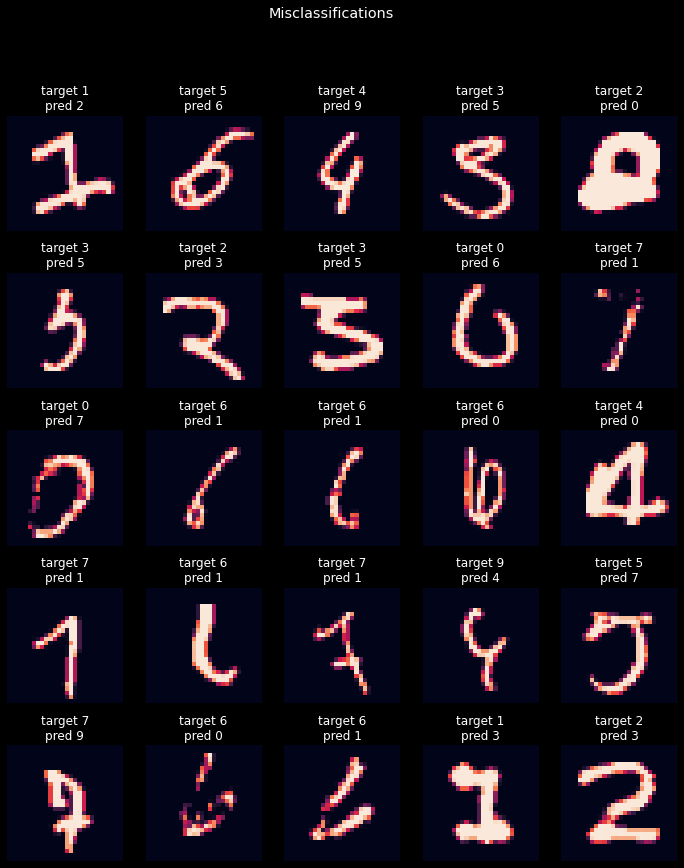

In [31]:
misclassified = get_misclassified(pure_bn,test_loader)
fig_misclassified=plot_misclassification(misclassified)

In [0]:
fig_misclassified.savefig('misclassified.png')

Total correctly classified : 9937


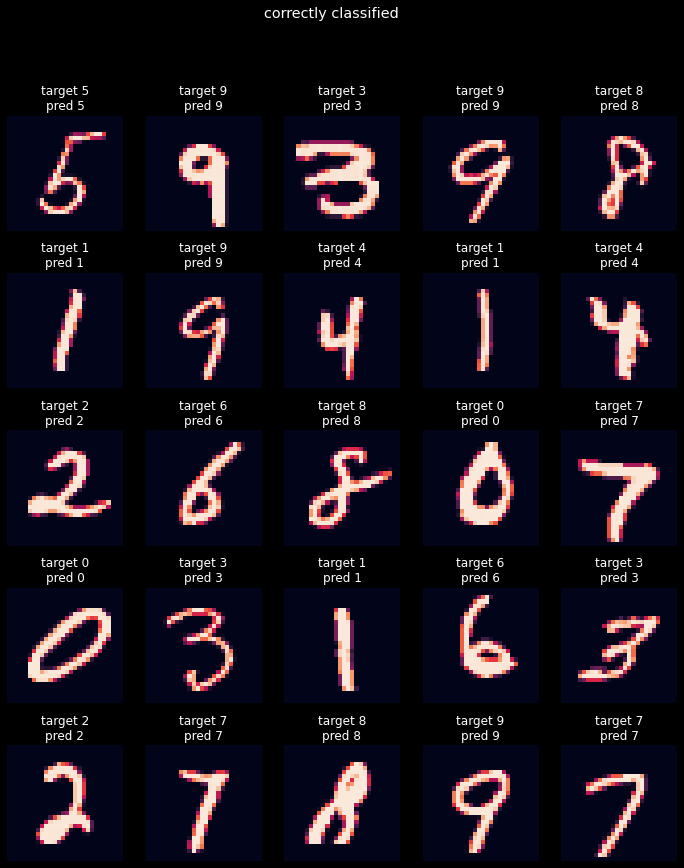

In [34]:
l2_model_1 = torch.load("/content/drive/My Drive/models s6/with L2 with BN.pt")
classified_correctly = get_classified_correctly(l2_model_1,test_loader)
classified_correctly_figure=plot_classification_correctly(classified_correctly)
classified_correctly_figure.savefig('classified_correctly.png')